In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
import statsmodels.api as sm
import matplotlib

# 设置字体为黑体，并解决负号显示问题
matplotlib.rcParams['font.family'] = 'SimHei'
matplotlib.rcParams['axes.unicode_minus'] = False

# 定义文件夹路径
info_folder = 'StockData/market_info'
data_folder = 'StockData/market_data'

# 创建字典存储股票相关信息数据
market_info = {}
# 读取 market_info 中的文件
for year in range(2014, 2025):
    file_name = f'hs300stocks_{year}.csv'
    file_path = os.path.join(info_folder, file_name)
    if os.path.isfile(file_path):
        data = pd.read_csv(file_path)
        market_info[f'year_{year}'] = data
    else:
        print(f'Warning: File {file_path} does not exist.')

# 创建字典存储股票具体数据
market_data = {}
# 读取 market_data 中的文件
for year in range(2014, 2025):
    file_name = f'hs300stocks_kdata_{year}.csv'
    file_path = os.path.join(data_folder, file_name)
    if os.path.isfile(file_path):
        data = pd.read_csv(file_path)
        market_data[f'year_{year}'] = data
    else:
        print(f'Warning: File {file_path} does not exist.')

# 合并所有年份的市场数据为一个数据框
combined_market_data = pd.concat(market_data.values(), ignore_index=True)

In [2]:
# 定义保存的文件路径
output_file_path = 'StockData/combined_market_data.csv'

# 将数据框保存为 CSV 文件
combined_market_data.to_csv(output_file_path, index=False, encoding='utf-8-sig')

print(f'数据已成功保存到 {output_file_path}')

数据已成功保存到 StockData/combined_market_data.csv


In [2]:
import pandas as pd

data = pd.read_csv(r"StockData/combined_market_data.csv", index_col=0)
print(data.head())
print(data.shape)

                           time         code      open      high       low  \
Unnamed: 0                                                                   
0           2014-01-02 15:00:00  szse.000001  5.662246  5.746339  5.629543   
1           2014-01-03 15:00:00  szse.000001  5.676262  5.680934  5.503404   
2           2014-01-06 15:00:00  szse.000001  5.554794  5.606184  5.372593   
3           2014-01-07 15:00:00  szse.000001  5.386609  5.494061  5.377265   
4           2014-01-08 15:00:00  szse.000001  5.437999  5.582825  5.386609   

               close    volume        amount  open_interest  
Unnamed: 0                                                   
0           5.713636  489910.0  5.962237e+08            NaN  
1           5.573482  551114.0  6.566313e+08            NaN  
2           5.452014  582118.0  6.792804e+08            NaN  
3           5.433327  338407.0  3.939776e+08            NaN  
4           5.494061  457768.0  5.384362e+08            NaN  
(770146, 9)


In [7]:
import os
import pandas as pd
import numpy as np
from arch import arch_model
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import matplotlib
import warnings

# 忽略 FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# 设置matplotlib支持中文显示
matplotlib.rcParams['font.family'] = 'SimHei'  # 设置字体为黑体
matplotlib.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# 定义文件夹路径
data_folder = 'StockData/market_data'

# 读取数据
combined_market_data = pd.concat([pd.read_csv(os.path.join(data_folder, f'hs300stocks_kdata_{year}.csv')) for year in range(2014, 2025)], ignore_index=True)

# 确保时间列为 datetime 类型
combined_market_data['time'] = pd.to_datetime(combined_market_data['time'], format='%Y/%m/%d %H:%M', errors='coerce')
combined_market_data.sort_values('time', inplace=True)

# 选择特定股票代码进行分析
stock_code = 'szse.000001'
stock_data = combined_market_data[combined_market_data['code'] == stock_code]

# 计算对数收益率
stock_data['log_return'] = np.log(stock_data['close']) - np.log(stock_data['close'].shift(1))
stock_data.dropna(subset=['log_return'], inplace=True)

# 计算风险指标
def calculate_risk_metrics(data):
    # 条件在险价值 (CoVaR)
    var_95 = np.percentile(data['log_return'], 5)
    cvar_95 = data[data['log_return'] <= var_95]['log_return'].mean()

    # 边际期望损失 (MES)
    mes = data[data['log_return'] <= var_95]['log_return'].mean()

    # 系统性风险指数 (SRISK)
    expected_loss = np.mean(data['log_return'])  # 假设为平均损失
    srisk = expected_loss / np.std(data['log_return'])

    # 成分期望损失 (CES)
    ces = np.mean(data['log_return'][data['log_return'] < 0])

    # 夏普比率 (Sharpe Ratio)
    sharpe_ratio = np.mean(data['log_return']) / np.std(data['log_return'])

    # 最大回撤 (Maximum Drawdown)
    cumulative_returns = (1 + data['log_return']).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()

    return {
        'CoVaR': cvar_95,
        'MES': mes,
        'SRISK': srisk,
        'CES': ces,
        'Sharpe Ratio': sharpe_ratio,
        'Maximum Drawdown': max_drawdown,
    }

risk_metrics = calculate_risk_metrics(stock_data)
print("风险指标:", risk_metrics)

# 准备数据用于LSTM模型
# 使用过去的30天数据预测下一天的波动率
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

# 计算对数收益率
stock_data.loc[:, 'log_return'] = np.log(stock_data['close']) - np.log(stock_data['close'].shift(1))
stock_data.dropna(subset=['log_return'], inplace=True)

# 使用GARCH模型计算波动率
# 先缩放数据
scaled_returns = stock_data['log_return'] * 100  # 缩放到1到1000之间

volatility_model = arch_model(scaled_returns, vol='Garch', p=1, q=1, rescale=False)
volatility_fit = volatility_model.fit(disp='off')
stock_data.loc[:, 'volatility'] = volatility_fit.conditional_volatility

# 使用过去30天的波动率预测下一天的波动率
X, y = create_dataset(stock_data['volatility'].values, time_step=30)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM模型
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# 交叉验证
kf = KFold(n_splits=5)
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0)
    y_val_pred = model.predict(X_val_fold)

    # 评估模型性能
    mse = mean_squared_error(y_val_fold, y_val_pred)
    r2 = r2_score(y_val_fold, y_val_pred)
    print(f'MSE: {mse:.4f}, R²: {r2:.4f}')

# 最终模型评估
y_test_pred = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f'测试集 MSE: {mse_test:.4f}, 测试集 R²: {r2_test:.4f}')

风险指标: {'CoVaR': -0.04974008319124417, 'MES': -0.04974008319124417, 'SRISK': 0.0003020559437707366, 'CES': -0.014247066930357304, 'Sharpe Ratio': 0.0003020559437707366, 'Maximum Drawdown': -0.7762844826321912}



C:\Users\13420\AppData\Local\Temp\ipykernel_28072\3180332031.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['log_return'] = np.log(stock_data['close']) - np.log(stock_data['close'].shift(1))
C:\Users\13420\AppData\Local\Temp\ipykernel_28072\3180332031.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data.dropna(subset=['log_return'], inplace=True)
D:\Anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale 



13/13 [==============================] - 1s 5ms/step
MSE: 0.0000, R²: 0.9893
13/13 [==============================] - 0s 4ms/step
MSE: 0.0000, R²: 0.9482
13/13 [==============================] - 0s 4ms/step
MSE: 0.0000, R²: 0.9899
13/13 [==============================] - 1s 6ms/step
MSE: 0.0000, R²: 0.9475
13/13 [==============================] - 0s 8ms/step
MSE: 0.0000, R²: 0.9929
17/17 [==============================] - 0s 9ms/step
测试集 MSE: 0.0000, 测试集 R²: 0.8161


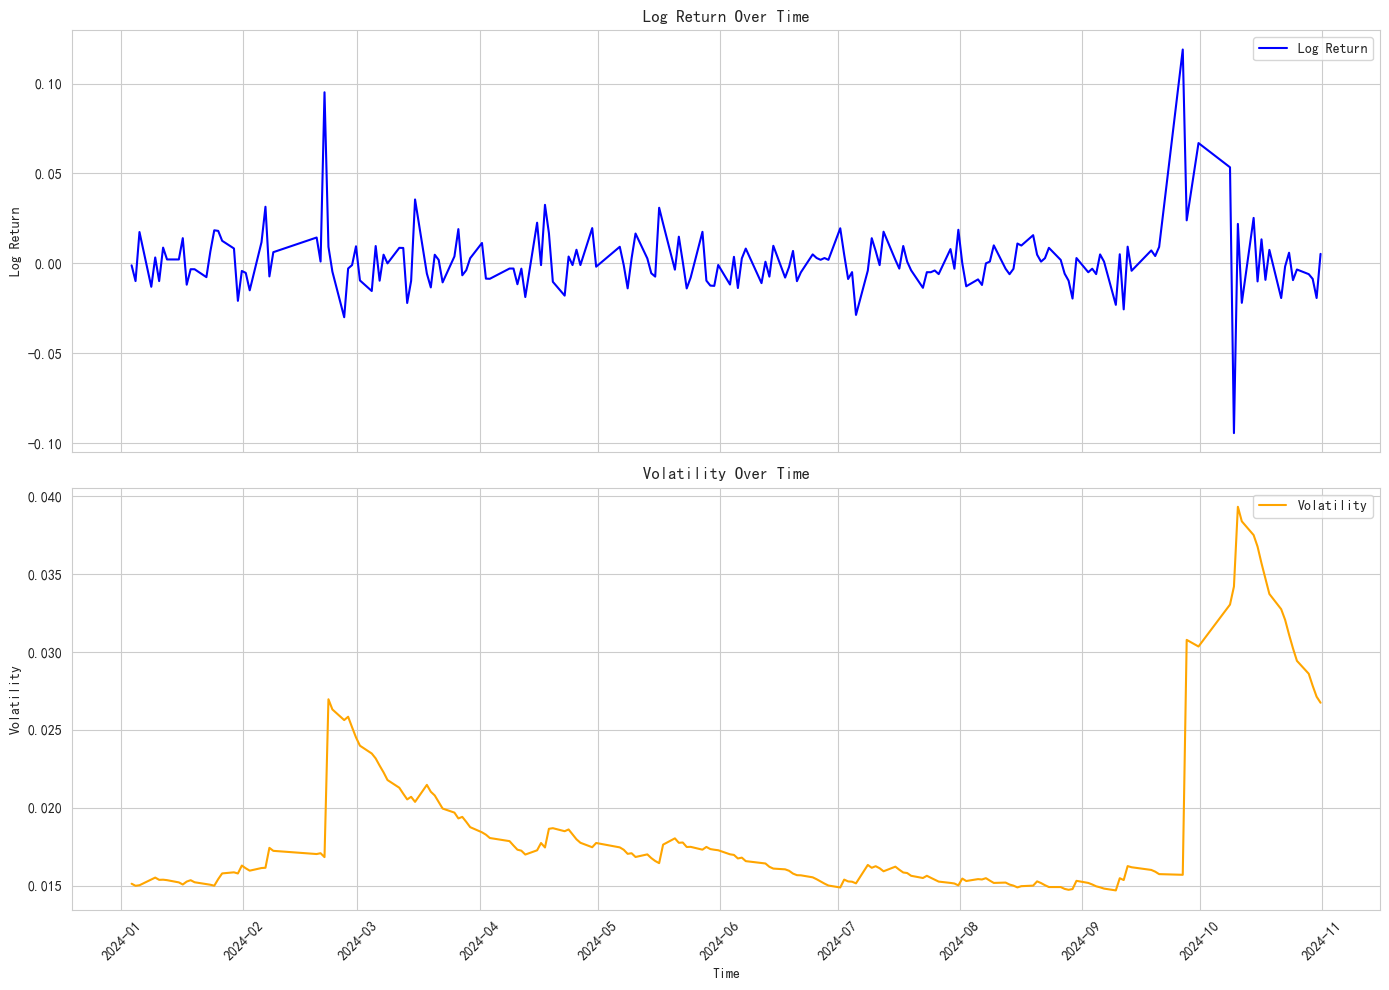

In [8]:
# 创建一个图形和两个子图
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# 绘制对数收益率
ax1.plot(stock_data['time'], stock_data['log_return'], color='blue', label='Log Return')
ax1.set_title('Log Return Over Time')
ax1.set_ylabel('Log Return')
ax1.legend()

# 绘制波动率
ax2.plot(stock_data['time'], stock_data['volatility'], color='orange', label='Volatility')
ax2.set_title('Volatility Over Time')
ax2.set_ylabel('Volatility')
ax2.set_xlabel('Time')
ax2.legend()

# 自动调整日期标签
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()